In [59]:
# Import all libraries
import pandas as pd
import os
import plotly.express as px
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import sys
sys.path.append('../src/')
from utils.map import us_remapping, plot_map

# Set the data folder
DATA_FOLDER = os.path.join(os.getcwd(), '../data/processed/')

# Load the data
df_beers = pd.read_parquet(DATA_FOLDER + 'beers.pq')
df_breweries = pd.read_parquet(DATA_FOLDER + 'breweries.pq')
df_users = pd.read_parquet(DATA_FOLDER + 'users.pq')
df_ratings_no_text = pd.read_parquet(DATA_FOLDER + 'ratings_no_text.pq')

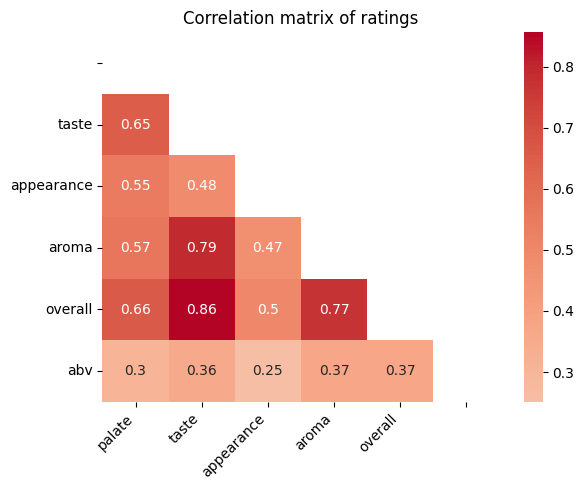

In [60]:
corr = df_ratings_no_text[['palate','taste','appearance','aroma','overall','abv']].corr()
xlabels = list(corr.columns[:-1]) + ['']
ylabels = [''] + list(corr.columns[1:])
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', center=0, xticklabels=xlabels, yticklabels=ylabels)
plt.title('Correlation matrix of ratings')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

<b>Rewrite them to make them suite in the narrative of the "popularity"</b>

Let's review for a moment the definition of palate, taste, appearance, aroma and overall, as defined by ratebeer:
- <b>Aroma</b>: the smell of the beer
- <b>Appearance</b>: the color, clarity, head and visual carbonation of the beer.
- <b>Taste</b>: the flavor of the beer, thinking about the palate, bitterness and finish.
- <b>Mouthfeel</b>: the body of the beer, the carbonation and the astrincency.
- <b>Overall</b>: the overall characteristics and the personal experience of the beer.

In this case we don't plot the rating since it's computed from all the other features but we'll use it to quantify the rating of a beer (rather than using the overall) since it takes into account all the other features. <br><br>
Appearance and Mouthfeel are each scored out of 5. Aroma and Taste are scored out of 10. While Overall is scored out of 20. These all combine to give the beer a total score out of 50, which is then divided and displayed as a score out of 5 for each rating.

Overall, taste and aroma have a strong connection. We see that this is reasonable since the taste and the smell of a beer are significant while expressing a preference for a beer and it's likely that users when evaluating the overall experience gives a high weight to these two factors (so if they are low, also the overall experience will be low). We see that while the appearance and the palate have a connection which is not negiglible (0.5 an 0.66) we see that this is less strong since it's reasonable to think that the appearance and the body of the beer impact less the overall rating, which makes this connection weaker

The correlation between the overall rating and ABV (0.37) is indeed less strong, which makes sense. While there is some relationship between alcohol content and the overall rating, the lower correlation suggests that ABV is not a dominant factor in how users rate a beer. This is intuitive because many beers have similar ABV ranges, and the experience can vary significantly based on other factors (like taste, aroma, or body). Therefore, even beers with the same ABV can lead to quite different user experiences, reducing the strength of the correlation between ABV and overall rating.

<b>Note</b> Here I'd add the correlation matrix (maybe change the plot if you don't like it) and I'd describe how the rating / popularity is linked with the different aspect of the ratings. I'd highlight the fact that the correlation between the ABV and the overall is still interesting because it proves what we observed in the ABV plots so I'd make a reference to the fact that we'll observe this phenomenon in the next sections. Let me know if you think we need to do some kind of temporal analysis (I think spatial would be too complex but let me know)

In [61]:
number_of_ratings_per_country = df_ratings_no_text.groupby('country_brewery').size().reset_index().rename(columns={0:'count'})
number_of_ratings_per_country = number_of_ratings_per_country[number_of_ratings_per_country['count'] > 250]
df_ratings_filtered = df_ratings_no_text[df_ratings_no_text['country_brewery'].isin(number_of_ratings_per_country['country_brewery'])]

average_rating_no_US = df_ratings_filtered[df_ratings_filtered['country_brewery'] != 'United States'].groupby('country_brewery')['rating'].mean().reset_index().rename(columns={'country_brewery':'location', 'rating':'count'})
average_rating_US = df_ratings_filtered[df_ratings_filtered['country_brewery'] == 'United States'].groupby('state_brewery')['rating'].mean().reset_index().rename(columns={'state_brewery':'location', 'rating':'count'})

options = {
    "title": "Beer Statistics by Country and US State",
    "plots": [{
        'label': 'Beers per country',
        'location_label': 'location',
        'z_label': 'count',
        'colorscale': 'Blues'
    }]
}

plot_map(average_rating_no_US, average_rating_US, options)

In [62]:
inverse_US_remapping = {v: k for k, v in us_remapping.items()}
average_rating_US['location'] = average_rating_US['location'].map(inverse_US_remapping)

average_rating = pd.concat([average_rating_no_US, average_rating_US]).sort_values('count', ascending=False)
average_rating.head(10)

,location,count
35,Oklahoma,3.647174
1,Alaska,3.629085
4,California,3.606804
34,Ohio,3.558601
12,Illinois,3.550495
36,Oregon,3.536218
47,Washington DC,3.516449
10,Belgium,3.505189
44,Vermont,3.502247
9,Georgia,3.493782


In [63]:
average_rating = pd.concat([average_rating_no_US, average_rating_US]).sort_values('count', ascending=True)
average_rating.head(10)

,location,count
52,Iran,1.499602
85,Nicaragua,1.847436
31,El Salvador,1.854768
44,Guatemala,1.858426
24,Cuba,1.929189
113,Uganda,1.932727
30,Egypt,1.934625
117,Venezuela,1.939033
28,Dominican Republic,1.982022
108,Tanzania,2.003830


In [64]:
unique_states_breweries = df_ratings_no_text['country_brewery'].unique()
row = []
for year in range(2002, 2018):
    df_state = df_ratings_no_text[df_ratings_no_text['date'].dt.year == year].groupby('country_brewery').agg({'rating': 'mean'}).reset_index()
    row += [{'year': year, 'state': state, 'avg_rating': abv} for state, abv in zip(df_state['country_brewery'], df_state['rating'])]
df_states = pd.DataFrame(row)

nbr_years_considered = df_states.groupby('state').agg({'year': 'count'}).reset_index()
nbr_years_considered = nbr_years_considered[nbr_years_considered['year'] == nbr_years_considered['year'].max()]
df_states = df_states[df_states['state'].isin(nbr_years_considered['state'])]

# Create frames for the animation
frames = [
    {
        "data": [
            px.choropleth(
                df_states[df_states['year'] == year],
                locations='state',
                locationmode='country names',
                color='avg_rating',
                color_continuous_scale='Viridis',
                range_color=[4, 8]
            ).data[0]
        ],
        "name": str(year),
    }
    for year in df_states['year'].unique()
]

# Define the figure with animation
fig_brewery = px.choropleth(
    df_states[df_states['year'] == df_states['year'].min()],
    locations='state',
    locationmode='country names',
    color='avg_rating',
    color_continuous_scale='Viridis',
    range_color=[1, 5]
)

fig_brewery.frames = frames

# Add slider to the layout
fig_brewery.update_layout(
    sliders=[{
        "steps": [
            {"args": [[str(year)], {"frame": {"duration": 300, "redraw": True}, "mode": "immediate"}],
             "label": str(year), "method": "animate"}
            for year in df_states['year'].unique()
        ],
        "transition": {"duration": 300},
        "x": 0.1,
        "xanchor": "left",
        "y": 0,
        "yanchor": "top"
    }],
    updatemenus=[{
        "buttons": [
            {"args": [None, {"frame": {"duration": 300, "redraw": True}, "fromcurrent": True}],
             "label": "Play", "method": "animate"},
            {"args": [[None], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate"}],
             "label": "Pause", "method": "animate"}
        ],
        "direction": "left",
        "pad": {"r": 10, "t": 87},
        "showactive": False,
        "type": "buttons",
        "x": 0.1,
        "xanchor": "right",
        "y": 0,
        "yanchor": "top"
    }]
)

fig_brewery.show()

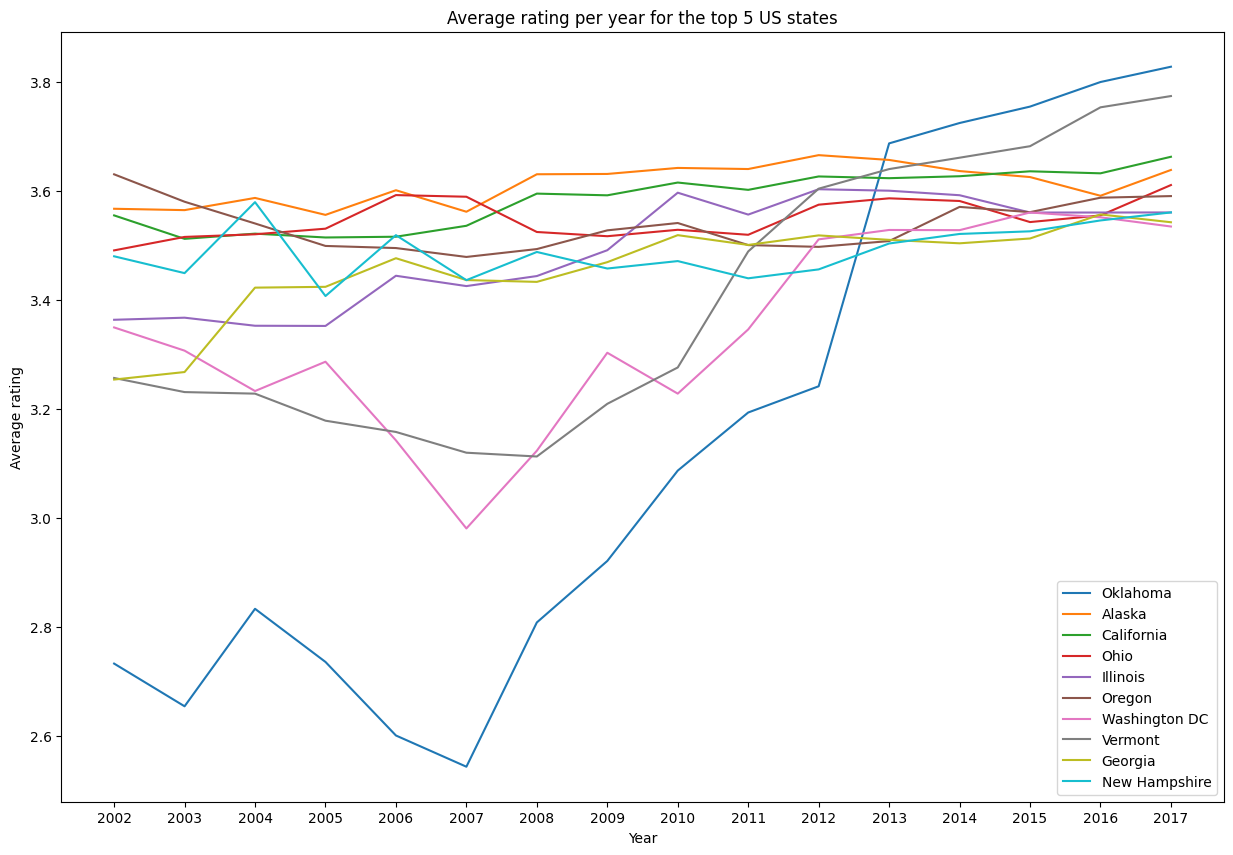

In [69]:
average_rating_US = average_rating_US.sort_values('count', ascending=False).head(10)
average_rating_no_US = average_rating_no_US.sort_values('count', ascending=False).head(10)
df_ratings_no_text['year'] = df_ratings_no_text['date'].dt.year
df_ratings_no_text = df_ratings_no_text[df_ratings_no_text['year'] >= 2002]
plt.figure(figsize=(15, 10))
for state in average_rating_US['location']:
    filtered = df_ratings_no_text[df_ratings_no_text['state_brewery'] == state].groupby('year').agg({'rating': 'mean'}).reset_index()
    plt.plot(filtered['year'], filtered['rating'], label=state)
plt.xlabel('Year')
plt.ylabel('Average rating')
plt.xticks(np.arange(2002, 2018, 1))
plt.legend()
plt.title('Average rating per year for the top 5 US states')
plt.show()

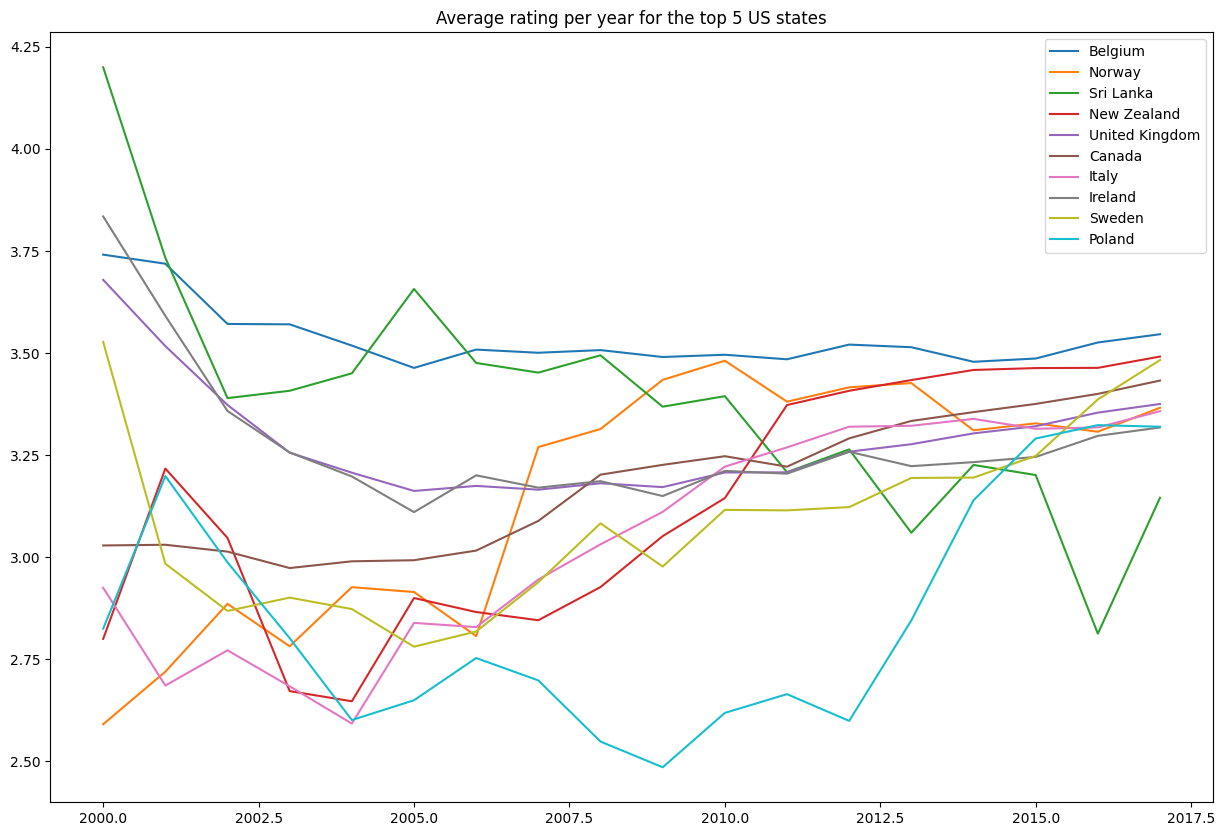

In [67]:
average_rating_US = average_rating_US.sort_values('count', ascending=False).head(10)
average_rating_no_US = average_rating_no_US.sort_values('count', ascending=False).head(10)
df_ratings_no_text['year'] = df_ratings_no_text['date'].dt.year
plt.figure(figsize=(15, 10))
for state in average_rating_no_US['location']:
    filtered = df_ratings_no_text[df_ratings_no_text['country_brewery'] == state].groupby('year').agg({'rating': 'mean'}).reset_index()
    plt.plot(filtered['year'], filtered['rating'], label=state)
plt.legend()
plt.title('Average rating per year for the top 5 US states')
plt.show()

There are lots of graphs so keep only what you fell like it's important. The main results imo are:
- Which countries produces better beer in terms of rating (choose if overall or you want also to plot the one with the time)
- The fact that over the time the difference in average rating between the different countries is getting smaller and smaller. This might introduce some additional considerations in the data story maybe?